# Classifying Shoppers Intention

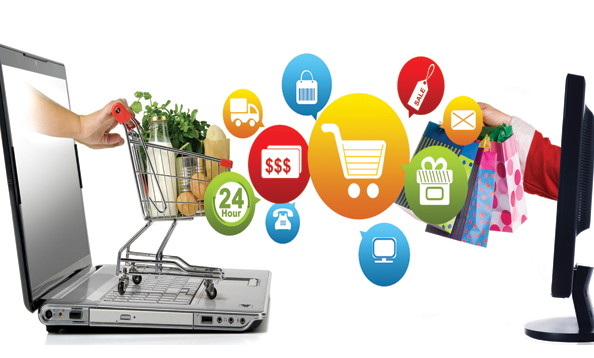

## Dataset Intro
The data set is a set of 18 features: 10 numerical and 8 categorical. This dataset has 12330 entries, split into 10,422 entries where the shoppers did not purchase and 1908 entries where the shoppers did purchase. Each entry is based on unique users in a 1-year period to avoid any trends specific to a specific campaign.

## Import Packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Loading Data

In [ ]:
df = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')
df.head()

## Column Descriptions:

**Administrative:** This is the number of pages of this type (administrative) that the user visited.

**Administrative_Duration:** This is the amount of time spent in this category of pages.

**Informational:** This is the number of pages of this type (informational) that the user visited.

**Informational_Duration:** This is the amount of time spent in this category of pages.

**ProductRelated:** This is the number of pages of this type (product related) that the user visited.

**ProductRelated_Duration:** This is the amount of time spent in this category of pages.

**BounceRates:** The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.

**ExitRates:** The percentage of pageviews on the website that end at that specific page.

**PageValues:** The average value of the page averaged over the value of the target page and/or the completion of an eCommerce transaction.

**SpecialDay:** This value represents the closeness of the browsing date to special days or holidays (eg Mother's Day or Valentine's day) in which the transaction is more likely to be finalized. More information about how this value is calculated below.

**Month:** Contains the month the pageview occurred, in string form.

**OperatingSystems:** An integer value representing the operating system that the user was on when viewing the page.

**Browser:** An integer value representing the browser that the user was using to view the page.

**Region:** An integer value representing which region the user is located in.

**TrafficType:** An integer value representing what type of traffic the user is categorized into.

**VisitorType:** A string representing whether a visitor is New Visitor, Returning Visitor, or Other.

**Weekend:** A boolean representing whether the session is on a weekend.

**Revenue:** A boolean representing whether or not the user completed the purchase.


## EDA

In [ ]:
df.describe(include='all')

In [ ]:
# Check for null values in data
nullcount = df.isnull().sum()
print('Total number of null values in dataset:', nullcount.sum())

Here we can see that there are no null values in the dataset.

In [ ]:
df.shape

In [ ]:
# Visualize the data
sns.countplot(df['Revenue'])
plt.ylim(0,12000)
plt.title('Was the transaction completed?', fontsize= 15)
plt.xlabel('Transaction Completed', fontsize=12)
plt.ylabel('Count (Entries)', fontsize=12)
plt.text(x=-.175, y=11000 ,s='10,422', fontsize=15)
plt.text(x=.875, y=2500, s='1908', fontsize=15)
plt.show()

Let's look at the distribution of numerical values

In [ ]:
df.select_dtypes(include=['int64', 'float64']).hist(figsize=(16,22))

In [ ]:
feats = df.drop('Revenue', axis=1)
target = df['Revenue']

In [ ]:
print(f'Features table has {feats.shape[0]} rows and {feats.shape[1]} columns')
print(f'Target table has {target.shape[0]} rows')

In [ ]:
# Checking for number of unique values for each feature
uniques = feats.nunique(axis=0)
print(uniques)

### Converting non-numercal columns to numerical

#### Binary columns

Convert 'Weekend' column to binary, rename to 'is_weekend'

In [ ]:
feats['Weekend'].value_counts()

In [ ]:
feats['Weekend'].value_counts().plot(kind='bar')

In [ ]:
feats['is_weekend'] = feats['Weekend'].apply(lambda row: 1 if row == True else 0)

In [ ]:
feats[['Weekend','is_weekend']].tail()

In [ ]:
feats.drop('Weekend', axis=1, inplace=True) 

### Categorical columns
The other columns are categorical so we will have to deal with them a little differently.

In [ ]:
feats['VisitorType'].value_counts()

In [ ]:
feats['VisitorType'].value_counts().plot(kind='bar')

We can see that there are three options for the `VisitorType` column, so we will make this a categorical column.

We can do this using the `get_dummies` function in the pandas library

In [ ]:
colname = 'VisitorType'
visitor_type_dummies = pd.get_dummies(feats[colname], prefix=colname)
pd.concat([feats[colname], visitor_type_dummies], axis=1).tail(n=10)

We can see that there is a bit of redundant information here, we have three total options, but we know that whenever two of the columns are zero, the other column *has* to be 1, since everyone has to fall into one of the three options. We can then drop one of the columns and assume that a zero in the remaining columns means that the dropped column is equal to one.

Here we will drop the `VisitorType_Other` column since it occurs with the least frequency.

In [ ]:
visitor_type_dummies.drop('VisitorType_Other', axis=1, inplace=True)
visitor_type_dummies.head()

Now we will join it back to the original dataset

In [ ]:
feats = pd.concat([feats, visitor_type_dummies], axis=1)
feats.drop('VisitorType', axis=1, inplace=True) 

Let's do the same for the `Month` column

In [ ]:
feats['Month'].value_counts()

Here we will drop the month of February since it occurs with the lowest frequency.

In [ ]:
colname = 'Month'
month_dummies = pd.get_dummies(feats[colname], prefix=colname)
month_dummies.drop(colname+'_Feb', axis=1, inplace=True)
feats = pd.concat([feats, month_dummies], axis=1)
feats.drop('Month', axis=1, inplace=True) 

In [ ]:
feats.iloc[0]

Let's check the data types to confirm that that the are all numerical

In [ ]:
feats.dtypes

#### Target variable

We can do a similar task to the target variable by making all the columns into numerical data types.

In [ ]:
target= target.apply(lambda row: 1 if row==True else 0)
target.head(n=10)

Currently the operating system, browser, region, traffic type columns are encoded as integer types. This may assume some order to the columns when in fact there is none. For example, a value for the operating system column of "2" does not mean it is two times a value of "1", since they are just arbitrary labels. Since they are categorical variables we will convert them into dummy variables as this will represent the data more appropriately.

First we will look at the `OperatingSystems` column.

In [ ]:
feats['OperatingSystems'].value_counts()

The value of "5" appears least, so that is the dummy column we will drop

In [ ]:
colname = 'OperatingSystems'
operation_system_dummies = pd.get_dummies(feats[colname], prefix=colname)
operation_system_dummies.drop(colname+'_5', axis=1, inplace=True)
feats = pd.concat([feats, operation_system_dummies], axis=1)

Repeat for the `Browser` column

In [ ]:
feats['Browser'].value_counts()

The value of "9" appears least, so that is the dummy column we will drop

In [ ]:
colname = 'Browser'
browser_dummies = pd.get_dummies(feats[colname], prefix=colname)
browser_dummies.drop(colname+'_9', axis=1, inplace=True)
feats = pd.concat([feats, browser_dummies], axis=1)

Repeat for the `TrafficType` column

In [ ]:
feats['TrafficType'].value_counts()

The value of "17" appears least, so that is the dummy column we will drop

In [ ]:
colname = 'TrafficType'
traffic_dummies = pd.get_dummies(feats[colname], prefix=colname)
traffic_dummies.drop(colname+'_17', axis=1, inplace=True)
feats = pd.concat([feats, traffic_dummies], axis=1)

Finally repeat for the `Region` column

In [ ]:
feats['Region'].value_counts()

The value of "5" appears least, so that is the dummy column we will drop

In [ ]:
colname = 'Region'
region_dummies = pd.get_dummies(feats[colname], prefix=colname)
region_dummies.drop(colname+'_5', axis=1, inplace=True)
feats = pd.concat([feats, region_dummies], axis=1)

Finally, drop all the original, unmodified columns

In [ ]:
drop_cols = ['OperatingSystems', 'Browser', 'TrafficType', 'Region']
feats.drop(drop_cols, inplace=True, axis=1)

Let's check the data types to confirm that that the are all numerical

In [ ]:
feats.dtypes

## Baseline model
A baseline model should be simple and well understood procedure, and the performance of this model should act as the bedrock for the lowest acceptable performance for any model we build.


In [ ]:
# caluclate the proportion of each target value
target.value_counts()/target.shape[0]*100

Now we can see that our baseline model would to predict '0', and that this with a 84.525547% accuracy.

In [ ]:
y_baseline = pd.Series(data=[0]*target.shape[0])

In [ ]:
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_pred=y_baseline, y_true=target, average='macro', zero_division=1)
print(f'Precision: {precision:.4f}\nRecall: {recall:.4f}\nfscore: {fscore:.4f}')

## Logistic regression model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=42)

In [ ]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

We fit our model first by instantiating it, then by fitting the model to the training data

In [ ]:
model = LogisticRegression(max_iter=10000,random_state=42)
model.fit(X_train, y_train)

To test the model performance we will predict the outcome on the test features (X_test), and compare those outcomes to real values (y_test)

In [ ]:
y_pred = model.predict(X_test)

Now let's compare against the true values. Let's start by using accuracy, accuracy is defined as the propotion of correct predictions out of the total predictions.

In [ ]:
accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'Accuracy of the model is {accuracy*100:.4f}%')

86.9830% - that's not bad with for a simple model with little feature engineering!

### Other evaluation metrics

Other common metrics in classification models are precision, recall, and f1-score.
Recall is defined as the proportion of correct positive predictions relative to total true postive values. Precision is defined as the proportion of correct positive predictions relative to total predicted postive values. F1 score is a combination of precision and recall, defined as 2 times the product of precision and recall, divided by the sum of the two.

It's useful to use these other evaluation metrics other than accuracy when the distribution of true and false values. We want these values to be as close to 1.0 as possible.

In [ ]:
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_pred=y_pred, y_true=y_test, average='binary')
print(f'Precision: {precision:.4f}\nRecall: {recall:.4f}\nfscore: {fscore:.4f}')

### Feature importances
   

We can look at which features are important by looking at the magnitude of the coefficients. Those with a larger coefficients will have a greater contribution to the result. Those with a positive value will make the result head toward the true result, that the customer will not subscribe. Features with a negative value for the coefficient will make the result heads towards a false result, that the customer will not subscribe to the product.

In [ ]:
coef_list = [f'{feature}: {coef}' for coef, feature in sorted(zip(model.coef_[0], X_train.columns.values.tolist()))]
for item in coef_list:
    print(item)

## Adding regularization to the model

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# help(LogisticRegressionCV)
Cs = np.logspace(-2, 6, 9)
model_l1 = LogisticRegressionCV(Cs=Cs, penalty='l1', cv=10, solver='liblinear', random_state=42, max_iter=10000)
model_l2 = LogisticRegressionCV(Cs=Cs, penalty='l2', cv=10, random_state=42, max_iter=10000)

model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)

In [ ]:
# best hyperparameters
print(f'Best hyperparameter for l1 regularization model: {model_l1.C_[0]}')
print(f'Best hyperparameter for l2 regularization model: {model_l2.C_[0]}')

In [ ]:
y_pred_l1 = model_l1.predict(X_test)
y_pred_l2 = model_l2.predict(X_test)

In [ ]:
accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)
accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
print(f'Accuracy of the model with l1 regularization is {accuracy_l1*100:.4f}%')
print(f'Accuracy of the model with l2 regularization is {accuracy_l2*100:.4f}%')

### Other evaluation metrics

Let's test again with the other evaluation metrics

In [ ]:
precision_l1, recall_l1, fscore_l1, _ = metrics.precision_recall_fscore_support(y_pred=y_pred_l1, y_true=y_test, average='binary')
precision_l2, recall_l2, fscore_l2, _ = metrics.precision_recall_fscore_support(y_pred=y_pred_l2, y_true=y_test, average='binary')
print(f'l1\nPrecision: {precision_l1:.4f}\nRecall: {recall_l1:.4f}\nfscore: {fscore_l1:.4f}\n\n')
print(f'l2\nPrecision: {precision_l2:.4f}\nRecall: {recall_l2:.4f}\nfscore: {fscore_l2:.4f}')

Overall the model with l2 performs slightly better.

### Feature importances
   
Examining the feature importances can show us how the regularization affected the values of the coefficients

In [ ]:
coef_list = [f'{feature}: {coef}' for coef, feature in sorted(zip(model_l1.coef_[0], X_train.columns.values.tolist()))]
for item in coef_list:
    print(item)

l1 regularization tends to send coefficients all the way down to zero, and is useful for reducing the total number of features in a training dataset. Here we can see some columns are very close to zero. 

Let's take a look at the the model coefficients for the model with l2 reglarization.

In [ ]:
coef_list = [f'{feature}: {coef}' for coef, feature in sorted(zip(model_l2.coef_[0], X_train.columns.values.tolist()))]
for item in coef_list:
    print(item)

Here we can see that none of the coefficients go right down to zero, which is rare when applying l2 regularization, this is because the feature coefficients get penalized less when they small, and much greater when the coefficients are larger.